In [1]:
import gymnasium
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, COMPLEX_MOVEMENT

In [2]:
def get_env(mode):
    env = gym_super_mario_bros.make('SuperMarioBros-v0', apply_api_compatibility=True, render_mode=mode)
    env = JoypadSpace(env, COMPLEX_MOVEMENT)
    return env

In [4]:
env = get_env('human')

done = True
for step in range(2500):
    if done:
        state = env.reset()[0]
    state, reward, done, truncated, info = env.step(env.action_space.sample())
    env.render()
env.close()

/Users/bifnudozhao/miniconda3/envs/tensorflow/lib/python3.9/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/Users/bifnudozhao/miniconda3/envs/tensorflow/lib/python3.9/site-packages/gym/envs/registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(
/Users/bifnudozhao/miniconda3/envs/tensorflow/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:272: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(


: 

observation 是一些 RGB 的图像，使用原始图像进行训练数据量太大了，所以需要将这个数量减少一下，通过将图片转化为灰度图片，然后再缩小来达到效果。

In [3]:
import matplotlib.pyplot as plt
from skimage.transform import resize
import numpy as np

def downscale_obs(obs, new_size=(42, 42), to_gray=True):
    if to_gray:
        return resize(obs, new_size, anti_aliasing=True).max(axis=2)
    else:
        return resize(obs, new_size, anti_aliasing=True)

/Users/bifnudozhao/miniconda3/envs/tensorflow/lib/python3.9/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/Users/bifnudozhao/miniconda3/envs/tensorflow/lib/python3.9/site-packages/gym/envs/registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(
/Users/bifnudozhao/miniconda3/envs/tensorflow/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:272: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(


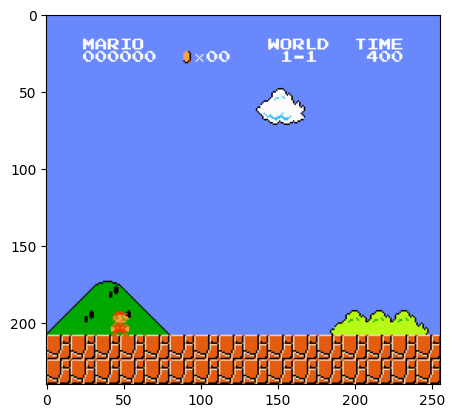

In [4]:
env = get_env('rgb_array')
env.reset()
plt.imshow(env.render())

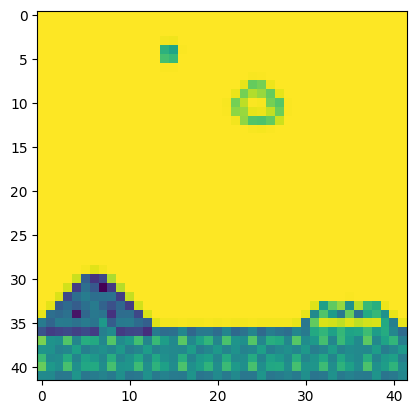

In [6]:
plt.imshow(downscale_obs(env.render()))

In [5]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from collections import deque

def prepare_state(state):
    return torch.from_numpy(downscale_obs(state, to_gray=True)).float().unsqueeze(dim=0)

# given an existing 3-frame state1 and a new single frame 2, adds the latest frame to
# the queue
def prepare_multi_state(state1, state2):
    state1 = state1.clone()
    tmp = torch.from_numpy(downscale_obs(state2, to_gray=True)).float()
    state1[0][0] = state1[0][1]
    state1[0][1] = state1[0][2]
    state1[0][2] = tmp
    return state1

def prepare_initial_state(state, N=3):
    state_ = torch.from_numpy(downscale_obs(state, to_gray=True)).float()
    tmp = state_.repeat((N, 1, 1))
    return tmp.unsqueeze(dim=0)

In [9]:
env.action_space

Discrete(12)

In [6]:
def policy(qvalues, eps=None):
    if eps is not None:
        if torch.rand(1) < eps:
            return torch.randint(low=0, high=11, size=(1,))
        else:
            return torch.argmax(qvalues)
    else:
        return torch.multinomial(F.softmax(F.normalize(qvalues)), num_samples=1)

In [7]:
from random import shuffle
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

class ExperienceReplay:
    def __init__(self, N=500, batch_size=100):
        self.N = N
        self.batch_size = batch_size
        self.memory = []
        self.counter = 0

    def add_memory(self, state1, action, reward, state2):
        self.counter += 1
        if self.counter % 500 == 0:
            self.shuffle_memory()

        # if the memory is not full, adds to the list
        # otherwise replaces a random memory with the new one
        if len(self.memory) < self.N:
            self.memory.append((state1, action, reward, state2))
        else:
            rand_index = np.random.randint(0, self.N - 1)
            self.memory[rand_index] = (state1, action, reward, state2)

    def shuffle_memory(self):
        shuffle(self.memory)

    def get_batch(self):
        if len(self.memory) < self.batch_size:
            batch_size = len(self.memory)
        else:
            batch_size = self.batch_size
        
        if len(self.memory) < 1:
            print('Error: No data in memory.')
            return None

        indexes = np.random.choice(np.arange(len(self.memory)), batch_size, replace=False)
        batch = [self.memory[i] for i in indexes]
        state1_batch = torch.stack([x[0].squeeze(dim=0) for x in batch], dim=0)
        action_batch = torch.Tensor([x[1] for x in batch]).long()
        reward_batch = torch.Tensor([x[2] for x in batch])
        state2_batch = torch.stack([x[3].squeeze(dim=0) for x in batch], dim=0)
        return state1_batch, action_batch, reward_batch, state2_batch

下面将实现 ICM 模块，其中包括三个模块：向前模块（forward model），反向模块（inverse model）以及一个编码器（encoder）。向前模块接受当前状态与动作，预测下一个状态；反向模块通过接受当前状态以及下一个状态来预测动作。编码器将一个三帧的状态输入转化为一个低维的内部状态。

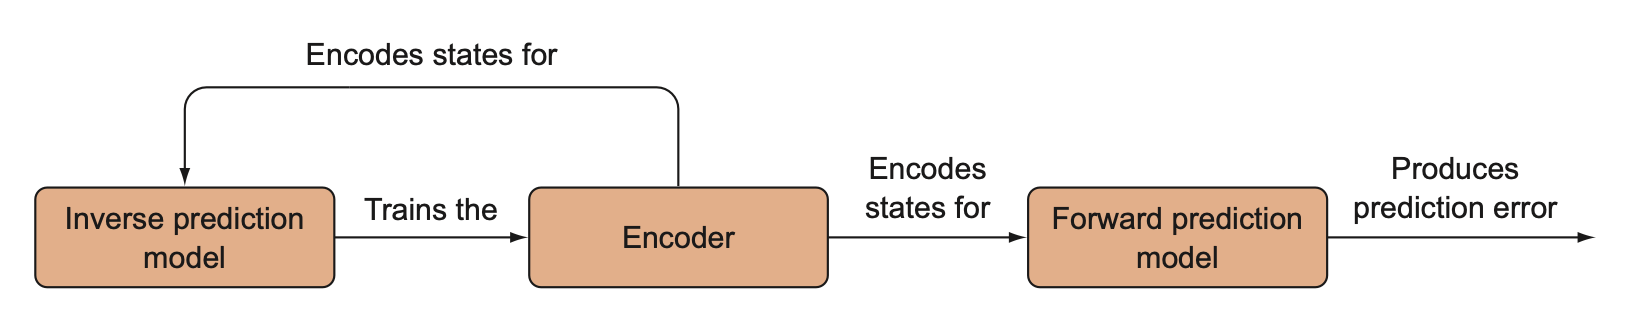

下面给出各个模块的输入输出。不过需要注意的是，由于当前使用的马里奥环境的动作空间是 18，所以对应的数字会适当变化。比如 $a_t$ 的形状应该是 $\R^{B \times 18}$

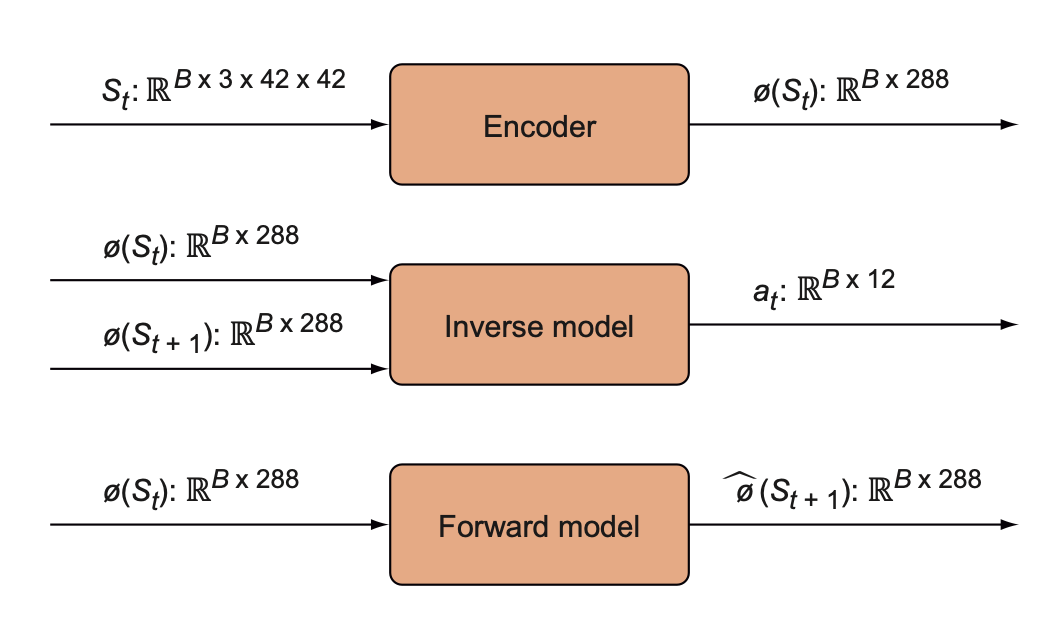

其中各模块架构如下：

- 向前模块：一个简单的两层线性网络，激活函数使用 `ReLU`，最后一层输出是下一个状态的值，所以不需要激活函数。
- 反向模块：一个简单的两层线性网络，激活函数也是使用 `ReLU`，不过输出由于是动作，所以使用 `Softmax` 来进行概率化。
- 编码器：一个四层卷积网络，激活函数使用 `ELU`。

整个算法如下图所示。

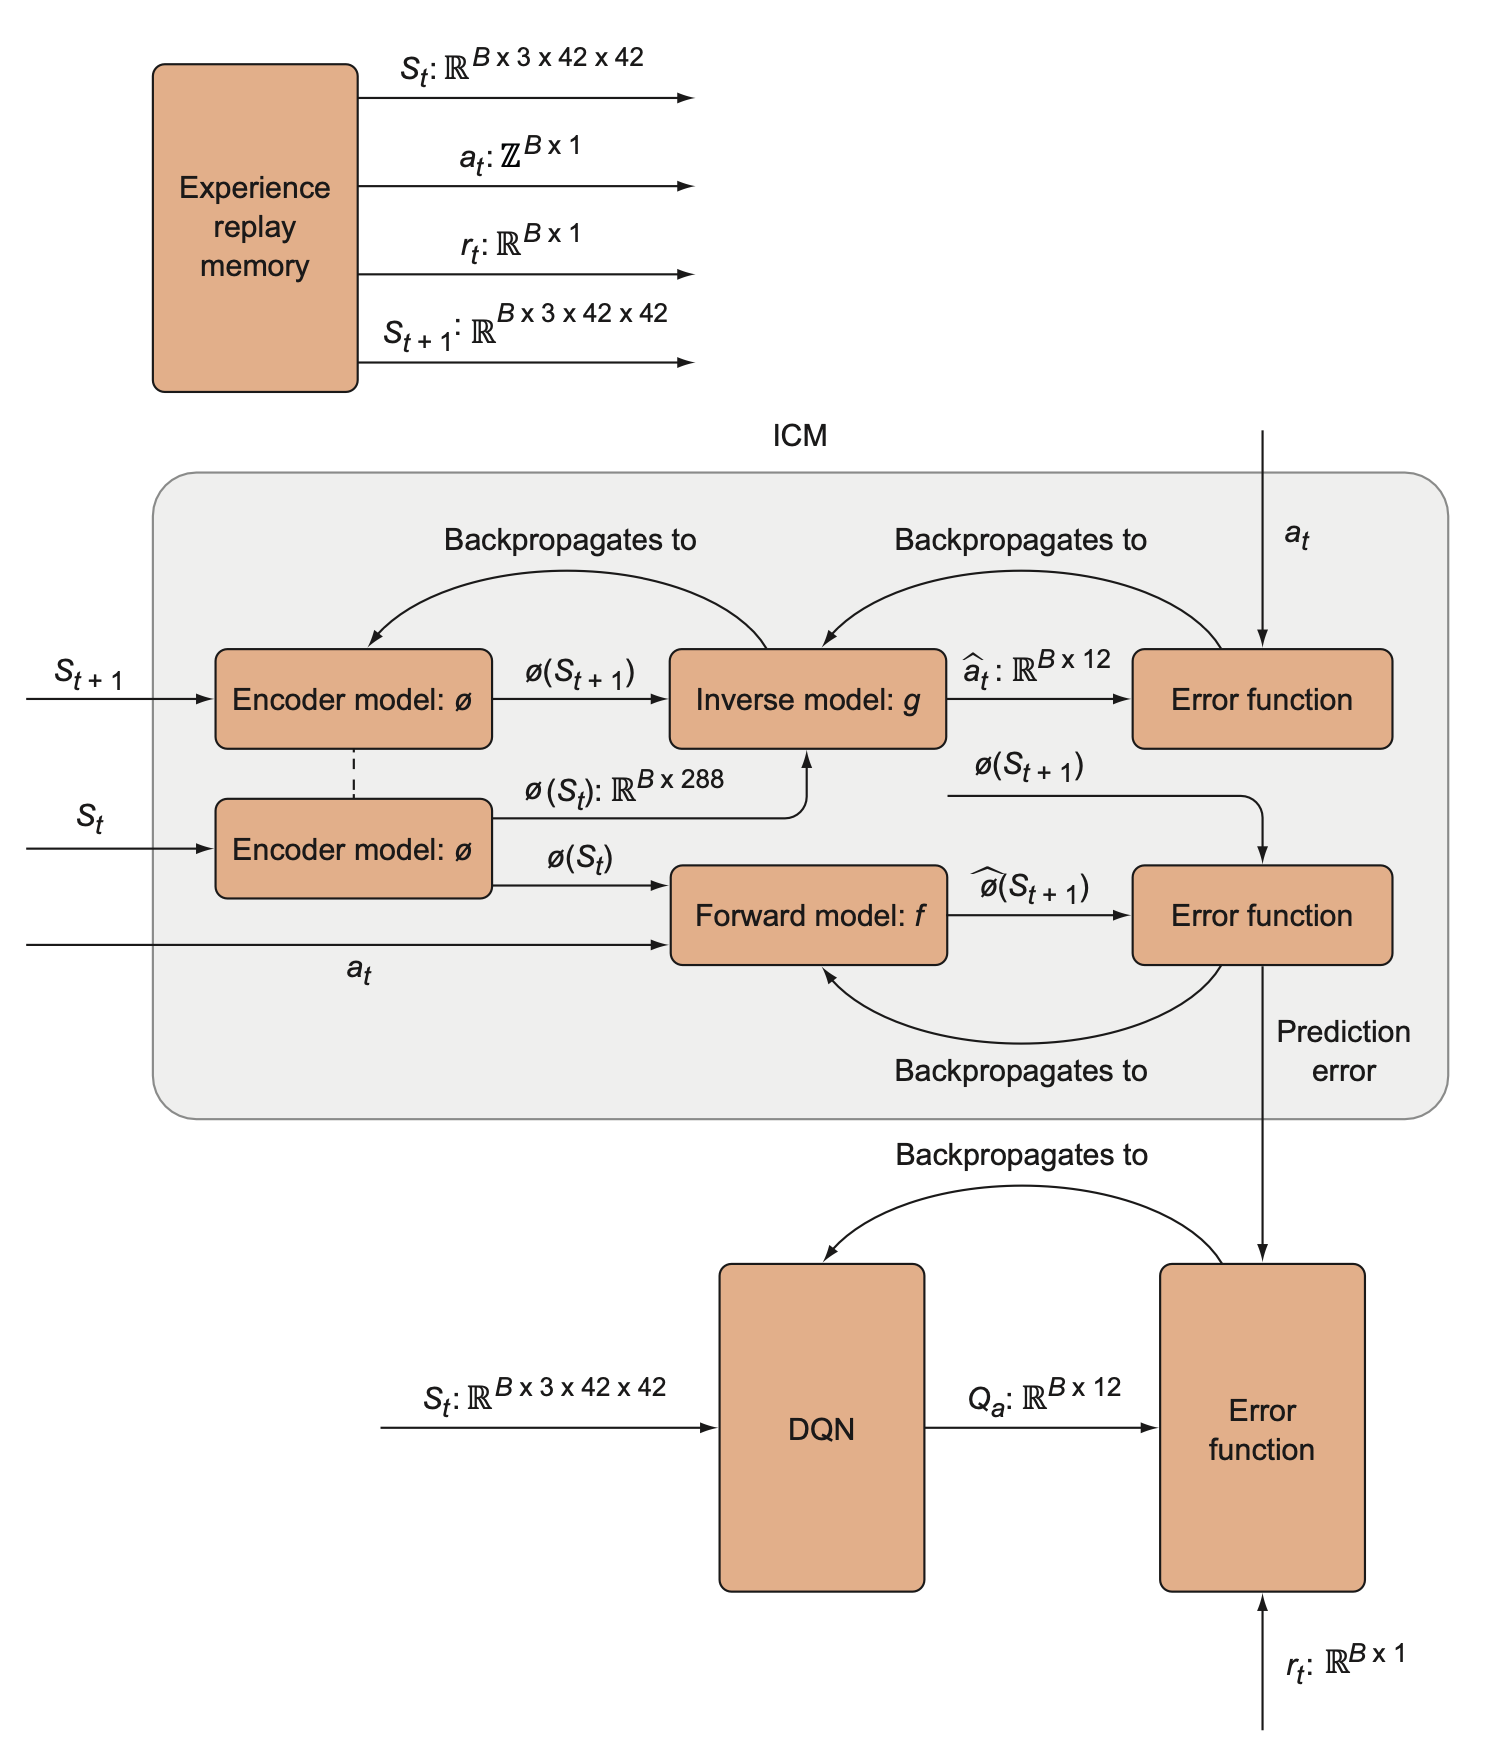

首先我们从经验回放中抽取 $B$ 个样本，将这些样本作为初始数据传入 ICM 以及 DQN，我们使用 ICM 的前馈网络计算出一个内部预测值；而 DQN 则使用这个内部预测值以及环境的外部奖励共同计算损失函数，从而进行学习。

In [10]:
# encoder
class Phi(nn.Module):
    def __init__(self):
        super(Phi, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3, 3), stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=2, padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=2, padding=1)

    def forward(self, x):
        X = F.normalize(x)
        Y = F.elu(self.conv1(x))
        Y = F.elu(self.conv2(Y))
        Y = F.elu(self.conv3(Y))
        Y = F.elu(self.conv4(Y)) # size [1, 32, 3, 3], batch, channels, 3x3
        Y = Y.flatten(start_dim=1) # size [N, 288]
        return Y

class Gnet(nn.Module):
    def __init__(self):
        super(Gnet, self).__init__()
        self.linear1 = nn.Linear(576, 256)
        self.linear2 = nn.Linear(256, 12)

    def forward(self, state1, state2):
        X = torch.cat((state1, state2), dim=1)
        Y = F.relu(self.linear1(X))
        Y = self.linear2(Y)
        Y = F.softmax(Y, dim=1)
        return Y

class Fnet(nn.Module):
    def __init__(self):
        super(Fnet, self).__init__()
        self.linear1 = nn.Linear(300, 256)
        self.linear2 = nn.Linear(256, 288)

    def forward(self, state, action):
        action_ = torch.zeros(action.shape[0], 12)
        indices = torch.stack((torch.arange(action.shape[0]), action.squeeze()), dim=0)
        indices = indices.tolist()
        action_[indices] = 1.
        X = torch.cat((state, action_), dim=1)
        Y = F.relu(self.linear1(X))
        Y = self.linear2(Y)
        return Y

In [11]:
class Qnetwork(nn.Module):
    def __init__(self):
        super(Qnetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=2, padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=2, padding=1)
        self.linear1 = nn.Linear(288, 100)
        self.linear2 = nn.Linear(100, 12)

    def forward(self, x):
        X = F.normalize(x)
        Y = F.elu(self.conv1(X))
        Y = F.elu(self.conv2(Y))
        Y = F.elu(self.conv3(Y))
        Y = F.elu(self.conv4(Y))
        Y = Y.flatten(start_dim=2)
        Y = Y.view(Y.shape[0], -1, 32)
        Y = Y.flatten(start_dim=1)
        Y = F.elu(self.linear1(Y))
        Y = self.linear2(Y)
        return Y

In [12]:
params = {
    'batch_size': 150,
    'beta': 0.2,
    'lambda': 0.1,
    'eta': 1.0,
    'gamma': 0.2,
    'max_episode_len': 100,
    'min_progress': 15,
    'action_repeats': 6,
    'frames_per_state': 3,
}

replay = ExperienceReplay(N=1000, batch_size=params['batch_size'])
Qmodel = Qnetwork()
encoder = Phi()
forward_model = Fnet()
inverse_model = Gnet()
forward_loss = nn.MSELoss(reduction='none')
inverse_loss = nn.CrossEntropyLoss(reduction='none')
qloss = nn.MSELoss()
all_model_params = list(Qmodel.parameters()) + list(encoder.parameters()) + \
    list(forward_model.parameters()) + list(inverse_model.parameters())
opt = optim.Adam(lr=0.001, params=all_model_params)

上面参数列表里涉及到一些对 loss 进行加权的参数，整体的 loss 定义如下

$$
\text{minimize} [\lambda \cdot Q_\text{loss} + (1 - \beta)F_\text{loss} + \beta \cdot G_\text{loss}]
$$

需要注意的是，DQN 的损失使用 $\lambda$，但前馈网络与反向网络共用参数 $\beta$，这是因为两者是关联的。整个网络的反向传播将由这个损失函数开始。

`max_episode_len` 与 `min_progress` 是用来防止卡死，因为有时候有些动作或者某些地方会让马里奥卡死。`action_repeats` 则用来做动作加强，比如策略选择函数选择了某个动作，则我们将重复这个动作 6 次，这能加快学习的速度。`frames_per_state` 表明我们用最近三帧作为当前的状态。

In [13]:
def loss_fun(q_loss, inverse_loss, forward_loss):
    loss_ = (1 - params['beta']) * inverse_loss
    loss_ += params['beta'] * forward_loss
    loss_ = loss_.sum() / loss_.flatten().shape[0]
    loss = loss_ + params['lambda'] * q_loss
    return loss

In [14]:
def reset_env():
    # env has to be initialized with render_mode `rgb_array`
    env.reset()
    state1 = prepare_initial_state(env.render())
    return state1

In [15]:
def ICM(state1, action, state2, forward_scale=1., inverse_scale=1e4):
    state1_hat = encoder(state1)
    state2_hat = encoder(state2)
    state2_hat_pred = forward_model(state1_hat.detach(), action.detach())
    forward_pred_err = forward_scale * \
        forward_loss(state2_hat_pred, state2_hat.detach()).sum(dim=1).unsqueeze(dim=1)
    pred_action = inverse_model(state1_hat, state2_hat)
    inverse_pred_err = inverse_scale * \
        inverse_loss(pred_action, action.detach().flatten()).unsqueeze(dim=1)
    return forward_pred_err, inverse_pred_err

In [16]:
def minibatch_train(use_extrinsic=True):
    state1_batch, action_batch, reward_batch, state2_batch = replay.get_batch()
    action_batch = action_batch.view(action_batch.shape[0], 1)
    reward_batch = reward_batch.view(reward_batch.shape[0], 1)

    forward_pred_err, inverse_pred_err = ICM(state1_batch, action_batch, state2_batch)
    i_reward = (1. / params['eta']) * forward_pred_err
    reward = i_reward.detach()

    if use_extrinsic:
        reward += reward_batch

    qvals = Qmodel(state2_batch)
    reward += params['gamma'] * torch.max(qvals)
    reward_pred = Qmodel(state1_batch)
    reward_target = reward_pred.clone()
    indices = torch.stack((torch.arange(action_batch.shape[0]), action_batch.squeeze()), dim=0)
    indices = indices.tolist()
    reward_target[indices] = reward.squeeze()
    q_loss = 1e5 * qloss(F.normalize(reward_pred), F.normalize(reward_target.detach()))
    return forward_pred_err, inverse_pred_err, q_loss

In [21]:
from IPython.display import clear_output

env = get_env('rgb_array')

epochs = 3500
env.reset()
state1 = prepare_initial_state(env.render())
eps = 0.15
losses = []
episode_length = 0
switch_to_eps_greedy = 1000
state_deque = deque(maxlen=params['frames_per_state'])
e_reward = 0.
# last_x_pos = env.env.env._x_position
last_x_pos = 0
ep_lengths = []
use_extrinsic = False
counter = 0

for i in range(epochs):
    counter += 1
    clear_output()
    print('%d / %d' % (counter, epochs))

    opt.zero_grad()
    episode_length += 1
    q_val_pred = Qmodel(state1)
    if i > switch_to_eps_greedy:
        action = int(policy(q_val_pred, eps))
    else:
        action = int(policy(q_val_pred))

    for j in range(params['action_repeats']):
        state2, e_reward_, done, truncated, info = env.step(action)
        last_x_pos = info['x_pos']
        if done:
            state1 = reset_env()
            break
        e_reward += e_reward_
        state_deque.append(prepare_state(state2))
    state2 = torch.stack(list(state_deque), dim=1)
    replay.add_memory(state1, action, e_reward, state2)
    e_reward = 0

    if episode_length > params['max_episode_len']:
        if (info['x_pos'] - last_x_pos) < params['min_progress']:
            done = True
        else:
            last_x_pos = info['x_pos']
    if done:
        ep_lengths.append(info['x_pos'])
        state1 = reset_env()
        # last_x_pos = env.env.env._x_position
        last_x_pos = info['x_pos']
        episode_length = 0
    else:
        state1 = state2

    if len(replay.memory) < params['batch_size']:
        continue

    forward_pred_err, inverse_pred_err, q_loss = minibatch_train(use_extrinsic=False)
    loss = loss_fun(q_loss, forward_pred_err, inverse_pred_err)
    loss_list = (q_loss.mean(), forward_pred_err.flatten().mean(), inverse_pred_err.flatten().mean())
    losses.append(loss_list)
    loss.backward()
    opt.step()

/Users/bifnudozhao/miniconda3/envs/tensorflow/lib/python3.9/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/Users/bifnudozhao/miniconda3/envs/tensorflow/lib/python3.9/site-packages/gym/envs/registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(
/Users/bifnudozhao/miniconda3/envs/tensorflow/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:272: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(


AttributeError: accessing private attribute '_x_position' is prohibited

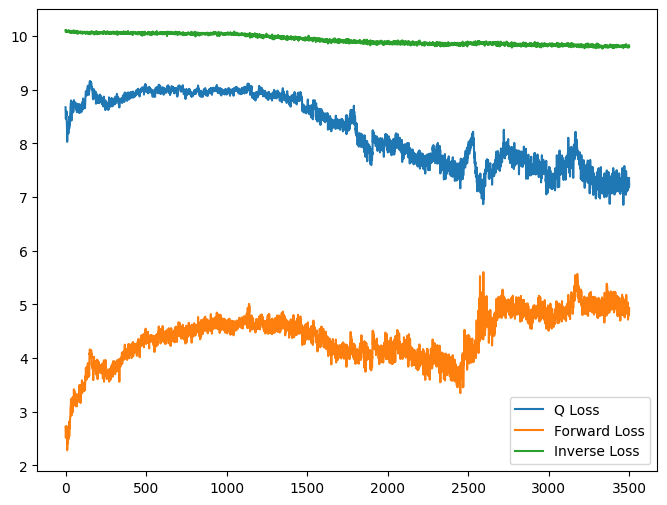

In [44]:
losses_ = np.array([(
    losses[i][0].detach().item(),
    losses[i][1].detach().item(),
    losses[i][2].detach().item(),
) for i in range(len(losses))])

plt.figure(figsize=(8, 6))
plt.plot(np.log(losses_[:, 0]), label='Q Loss')
plt.plot(np.log(losses_[:, 1]), label='Forward Loss')
plt.plot(np.log(losses_[:, 2]), label='Inverse Loss')
plt.legend()
plt.show()

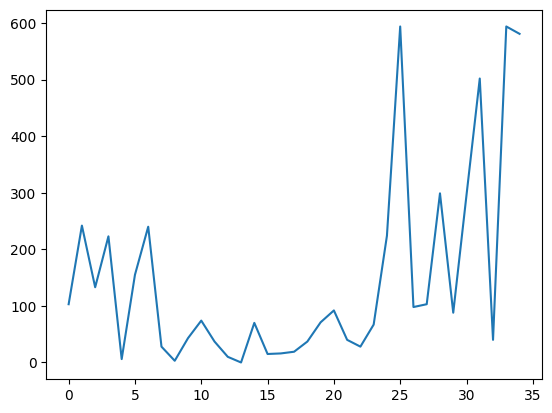

In [45]:
plt.figure()
plt.plot(np.array(ep_lengths), label='episode length')

In [50]:
torch.save(Qmodel.state_dict(), '../results/mario_with_icm/qmodel')
torch.save(forward_model.state_dict(), '../results/mario_with_icm/fnet')
torch.save(inverse_model.state_dict(), '../results/mario_with_icm/gnet')

In [20]:
import imageio

Qmodel.load_state_dict(torch.load('../results/mario_with_icm/qmodel'))

eps = 0.1
done = True
state_deque = deque(maxlen=params['frames_per_state'])
env = get_env('rgb_array')
writer = imageio.get_writer('mario.mp4', fps=60)
for step in range(5000):
    if done:
        env.reset()
        state1 = prepare_initial_state(env.render())
    q_val_pred = Qmodel(state1)
    action = int(policy(q_val_pred, eps))
    state2, reward, done, truncated, info = env.step(action)
    state2 = prepare_multi_state(state1, state2)
    state1 = state2
    frame = env.render()
    imageio.imwrite('tmp.png', frame)
    writer.append_data(imageio.imread('tmp.png'))
env.close()
writer.close()

/Users/bifnudozhao/miniconda3/envs/tensorflow/lib/python3.9/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/Users/bifnudozhao/miniconda3/envs/tensorflow/lib/python3.9/site-packages/gym/envs/registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(
/Users/bifnudozhao/miniconda3/envs/tensorflow/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:272: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(
/var/folders/63/hmm24s352qv_4vs09n66p97m0000gn/T/ipykernel_44444/3336641029.py:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the curr